In [1]:
import itertools
import pathlib

import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms

import lab.metrics
import lab.analytics

sns.set_style("white")
plt.rcParams.update({
    'font.size': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 8,
})
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

WITH_GRID = False

In [2]:
DEFENCE = "tamaraw"
SETTING = "mconn"
INPUTS = [
    f"../../results/ml-eval-{SETTING}/{path}/predict/{classifier}.csv"
    for classifier in ["kfp-0", "dfnet-0", "varcnn-0"]
    for path in [DEFENCE, "undefended"] + ([f"simulated-{DEFENCE}"] if SETTING == "conn" else [])
]
OUTPUT_FILE = pathlib.Path("/tmp/plot.png")
WITH_LEGEND = True
WITH_SIMULATED = (SETTING == "conn")

if "snakemake" in globals():
    INPUTS = list(snakemake.input)
    OUTPUT_FILE = pathlib.Path(snakemake.output[0])
    WITH_LEGEND = snakemake.params.get("with_legend", False)
    WITH_SIMULATED = snakemake.params.get("with_simulated", True)

In [3]:
def _load_data(inputs):
    data = (pd.concat([
                pd.read_csv(fname, header=0) for fname in inputs
            ], keys=inputs, names=["path"])
            .fillna(0)
            .rename(columns=lambda c: int(c) if c != "y_true" else c)
            .astype({"y_true": int})
            .drop(columns=[-1])
            .assign(
                is_simulated=lambda x: x.index.get_level_values("path").str.contains("simulated"),
                defence=lambda x: x.index.get_level_values("path").map(
                    lambda s: next(defence for defence in ["front", "tamaraw", "undefended"] if defence in s)
                ),
                classifier=lambda x: x.index.get_level_values("path").map(
                    lambda s: next(classifier for classifier in ["kfp", "dfnet", "varcnn"] if classifier in s)
                ))
            .set_index(["defence", "classifier", "is_simulated"])
            .rename(index={"front": "FRONT", "tamaraw": "Tamaraw", "undefended": "Undefended",
                           "kfp": "$k$-FP", "dfnet": "DF", "varcnn": "Var-CNN"})
           )
    return data

data = _load_data(INPUTS)
data

y_true         0         1             2  \
defence    classifier is_simulated                                             
Tamaraw    $k$-FP     False             -1  0.000000  0.000000  0.000000e+00   
                      False             -1  0.000000  0.000000  0.000000e+00   
                      False             -1  0.000000  0.000000  0.000000e+00   
                      False             -1  0.000000  0.000000  0.000000e+00   
                      False             -1  0.000000  0.000000  0.000000e+00   
...                                    ...       ...       ...           ...   
Undefended Var-CNN    False             99  0.442302  0.000027  2.294371e-06   
                      False             99  0.531106  0.000015  1.003277e-06   
                      False             99  0.597672  0.000013  6.413883e-07   
                      False             99  0.659740  0.000011  4.304709e-07   
                      False             99  0.678913  0.000005  1.167814e-07   

                                               3             4             5  \
defence    classifier is_simulated                                             
Tamaraw    $k$-FP     False         0.000000e+00  0.000000e+00  0.000000e+00   
                      False         0.000000e+00  0.000000e+00  0.000000e+00   
                      False         0.000000e+00  6.666667e-01  0.000000e+00   
                      False         0.000000e+00  0.000000e+00  0.000000e+00   
                      False         0.000000e+00  0.000000e+00  0.000000e+00   
...                                          ...           ...           ...   
Undefended Var-CNN    False         2.040872e-06  1.541963e-05  5.107551e-07   
                      False         1.355548e-06  8.146240e-06  9.743352e-07   
                      False         1.150026e-06  2.086121e-06  6.811787e-07   
                      False         4.293091e-07  1.667884e-06  1.723535e-07   
                      False         1.457733e-07  6.524768e-07  7.381516e-08   

                                               6         7         8  ...  \
defence    classifier is_simulated                                    ...   
Tamaraw    $k$-FP     False         0.000000e+00  0.000000  0.000000  ...   
                      False         0.000000e+00  0.000000  0.000000  ...   
                      False         0.000000e+00  0.000000  0.166667  ...   
                      False         0.000000e+00  0.000000  0.000000  ...   
                      False         0.000000e+00  0.000000  0.000000  ...   
...                                          ...       ...       ...  ...   
Undefended Var-CNN    False         7.166931e-07  0.000026  0.000008  ...   
                      False         4.954188e-07  0.000023  0.000012  ...   
                      False         2.351680e-07  0.000015  0.000026  ...   
                      False         3.247890e-07  0.000015  0.000001  ...   
                      False         1.599705e-07  0.000005  0.000002  ...   

                                              90            91            92  \
defence    classifier is_simulated                                             
Tamaraw    $k$-FP     False         0.000000e+00  0.000000e+00  0.000000e+00   
                      False         0.000000e+00  0.000000e+00  0.000000e+00   
                      False         0.000000e+00  0.000000e+00  0.000000e+00   
                      False         0.000000e+00  0.000000e+00  5.000000e-01   
                      False         0.000000e+00  0.000000e+00  0.000000e+00   
...                                          ...           ...           ...   
Undefended Var-CNN    False         7.213757e-07  3.184108e-07  2.886268e-06   
                      False         4.291650e-07  1.945926e-07  1.723314e-06   
                      False         2.162083e-07  4.758294e-07  1.029087e-06   
                      False         6.602653e-08  1.052436e-07  2.049260

In [4]:
def precision_recall_curve(df):
    result = lab.analytics.rprecision_recall_curve(df["y_true"], df.drop("y_true", axis=1), ratio=20)
    return pd.DataFrame({
        "precision": result.precision,
        "recall": result.recall,
    })

# def plot_pr_curve(data):
#     data = (data
#             .transform(lambda x: x*100)
#             .rename({"dfnet": "DF", "varcnn": "Var-CNN", "p1fp": "$p$-FP(C)", "kfp": "$k$-FP"}, axis=0)
#             .rename({"precision": "$\pi_{20}$ (\%)", "recall": "Recall (\%)"}, axis=1)
#             .reset_index())
#     display(data)
# 
#     with plt.style.context([]):#"./mpl-style/pr-curve.mplstyle", "./mpl-style/pets.mplstyle", {"text.usetex": True}]):
#         grid = sns.relplot(
#             data=data, x="Recall (\%)", y="$\pi_{20}$ (\%)", hue="factor",
#             style="factor", col="classifier", kind="line", 
#             facet_kws=dict(legend_out=True, despine=False,
#                            gridspec_kws=dict(wspace=.1)),
#             palette="binary", legend=True
#         )
#         grid.set_titles(col_template="{col_name}")
#         
#         for i, ax in enumerate(np.ravel(grid.axes)):
#             # if i == 0:
#             #     ax.legend(labels=["Unmon.", "Control", "Both"])
#             ax.set_xticks([0, 50, 100])
#             ax.set_yticks([0, 50, 100])
#             ax.xaxis.get_major_formatter()._usetex = False
#             ax.yaxis.get_major_formatter()._usetex = False
#         
#     return grid

In [5]:
pr_scores = (data.groupby(["defence", "classifier", "is_simulated"])
             .apply(lambda x: precision_recall_curve(x)))
             # .set_index("thresholds", append=True))
pr_scores

precision  recall
defence    classifier is_simulated                       
Tamaraw    $k$-FP     False        0     0.042000  0.8820
                                   1     0.082452  0.8810
                                   2     0.082452  0.8810
                                   3     0.095601  0.8770
                                   4     0.148526  0.8290
...                                           ...     ...
Undefended Var-CNN    False        280   1.000000  0.8430
                                   281   1.000000  0.8190
                                   282   1.000000  0.7775
                                   283   1.000000  0.0000
                                   284   1.000000  0.0000

[1746 rows x 2 columns]

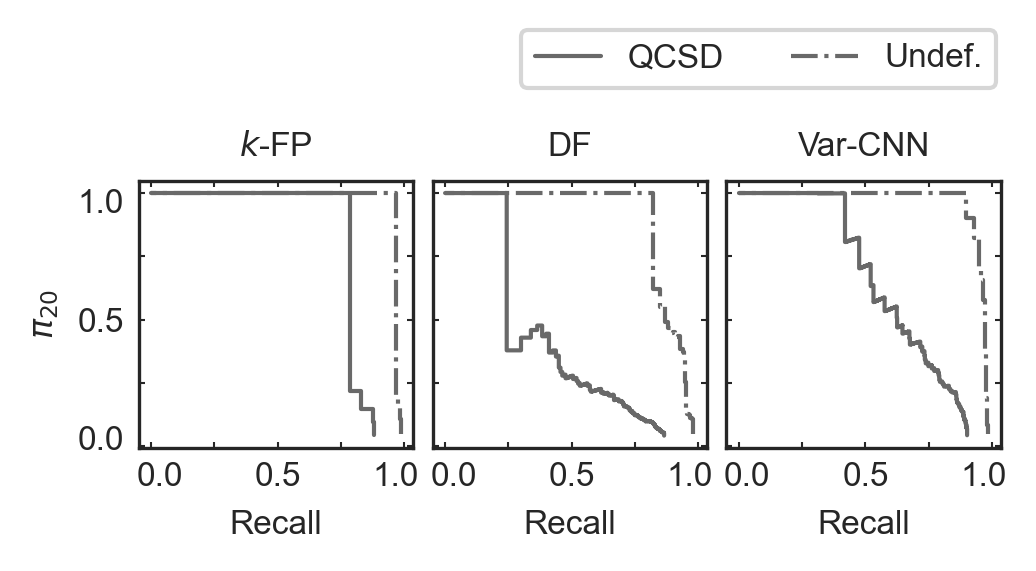

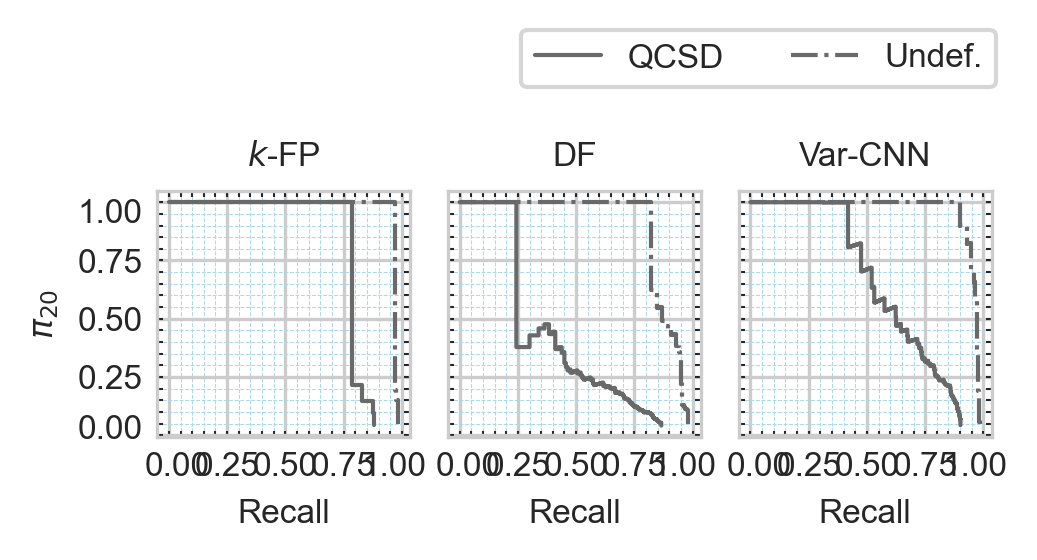

In [12]:
linestyles = {
    "Undef.": "-.",
    "Simulated": ":",
    "QCSD": "-"
}
    
    

def plot_pr_curves(plot_data, with_grid=False):
    if not WITH_SIMULATED:
        plot_data = plot_data.xs(False, level="is_simulated", drop_level=False)
    
    fig, axes_arr = plt.subplots(1, 3, figsize=(3.5, 2), sharex=True, sharey=True, dpi=300)
    for classifier, axes in  zip(plot_data.index.unique("classifier"), axes_arr.ravel()):
        for defence, color in zip(plot_data.index.unique("defence"), ["#1f77b4", "#ff7f0e"]):
            for is_simulated in [False, True]:
                if (
                    defence == "Undefended" and is_simulated
                    or is_simulated and not WITH_SIMULATED
                ):
                    continue
                
                label = "QCSD" if not is_simulated else "Simulated"
                # label = defence if defence == "Undefended" else f"{defence} ({label})"
                label = defence if defence == "Undefended" else label
                if label == "Undefended":
                    label = "Undef."
                
                axes.step(
                    plot_data["recall"][defence][classifier][is_simulated],
                    plot_data["precision"][defence][classifier][is_simulated],
                    label=label,
                    linestyle=linestyles[label],
                    color="dimgray",
                    linewidth=1,
                )
        axes.set_xlabel("Recall")
        for axis in [axes.xaxis, axes.yaxis]:
            axis.set_major_locator(ticker.FixedLocator([0, .5, 1]))
            axis.set_minor_locator(ticker.MultipleLocator(.25))
            
        if with_grid:
            axes.grid(True, which="minor", axis="both", color="lightblue", linestyle="--", linewidth=.25)
            axes.yaxis.set_major_locator(ticker.FixedLocator([0, .25, .5, .75, 1]))
            axes.yaxis.set_minor_locator(ticker.MultipleLocator(.05))
            axes.xaxis.set_minor_locator(ticker.MultipleLocator(.05))
            axes.xaxis.set_major_locator(ticker.FixedLocator([0, .25, .5, .75, 1]))
        
        axes.set_title(classifier)
        axes.set_aspect("equal")
        axes.margins(0.05)
        axes.tick_params(
            axis='both', which='both', bottom=True, top=True, right=True, left=True,
            direction="in", width=.5, length = 1.5,
            
        )
        
        
    for axes in axes_arr:
        tick_label = axes.xaxis.get_majorticklabels()[0]
        offset = matplotlib.transforms.ScaledTranslation(2/72, 0, fig.dpi_scale_trans)
        tick_label.set_transform(tick_label.get_transform() + offset)
        
        tick_label = axes.xaxis.get_majorticklabels()[-1]
        offset = matplotlib.transforms.ScaledTranslation(-2/72, 0, fig.dpi_scale_trans)
        tick_label.set_transform(tick_label.get_transform() + offset)
        
    axes = axes_arr[0]
    tick_label = axes.yaxis.get_majorticklabels()[0]
    offset = matplotlib.transforms.ScaledTranslation(0, 2/72, fig.dpi_scale_trans)
    tick_label.set_transform(tick_label.get_transform() + offset)

    tick_label = axes.yaxis.get_majorticklabels()[-1]
    offset = matplotlib.transforms.ScaledTranslation(0, -2/72, fig.dpi_scale_trans)
    tick_label.set_transform(tick_label.get_transform() + offset)
        
    axes_arr[0].set_ylabel("$\pi_{20}$")
    axes_arr[0].yaxis.get_label().set_bbox(dict(boxstyle="square,pad=0", fc="none", ec="none"))
    handles, labels = axes_arr[0].get_legend_handles_labels()
    
    fig.tight_layout(w_pad=.25)
    fig.subplots_adjust(wspace=None, hspace=None)
    
    if WITH_LEGEND:
        fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(.97, .85), ncol=3)
    return fig

with sns.axes_style("white"):
    fig = plot_pr_curves(pr_scores)
    fig.savefig(OUTPUT_FILE.with_suffix(".png"), bbox_inches="tight", dpi=150)
    fig.savefig(OUTPUT_FILE.with_suffix(".pgf"), backend="pgf", bbox_inches="tight")
    fig.savefig(OUTPUT_FILE.with_suffix(".pdf"), backend="pgf", bbox_inches="tight")
    
with sns.axes_style("whitegrid"):
    fig2 = plot_pr_curves(pr_scores, with_grid=True)
    fig2.savefig(OUTPUT_FILE.with_suffix(".grid.pdf"), backend="pgf", bbox_inches="tight")